Import required modules

In [6]:
from datetime import datetime
import helper as hp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Set Required Base Path (*Note*: relative paths or $Home (~) directory not working)

In [7]:
hp.FIRED_BASE_FOLDER = "<Set directory of FIRED>"

startDay = "2020.06.13" # None to select dataset first day
stopDay = "2020.07.15" # None to select dataset last day (timepoint) 
includeMeters = [] # if empty, all are used

Gather some information about the dataset

In [8]:
# Mapping from meter device -> metered appliance
deviceMapping = hp.getDeviceMapping()

# will select min(stopDay, lastDayOfDataset) and max(startDay, firstDayOfDataset)
start, end = hp.getRecordingRange(startDay, stopDay)
duration = end-start
print("Time of Interest: " + hp.time_format_ymdhms(start) + " -> " + hp.time_format_ymdhms(end))

smartMeterName = hp.getSmartMeter()
meterNames = hp.getMeterList() + [smartMeterName]
if len(includeMeters) > 0: meterNames = [m for m in meterNames if m in includeMeters]
print("Meters of Interest: " + str(meterNames))



Time of Interest: 2020.06.14 00:00:00.000 -> 2020.07.15 00:00:00.000
Meters of Interest: ['powermeter08', 'powermeter09', 'powermeter10', 'powermeter11', 'powermeter12', 'powermeter13', 'powermeter14', 'powermeter15', 'powermeter16', 'powermeter17', 'powermeter18', 'powermeter19', 'powermeter20', 'powermeter21', 'powermeter22', 'powermeter23', 'powermeter24', 'powermeter25', 'powermeter26', 'powermeter27', 'powermeter28', 'smartmeter001']


Load the 50Hz data for the given days of dataset and given meters. Use the apparent and reactive power to identify gaps in the original voltage and current waveform data. Gaps have been filled with 0s s.t. timestamps are preserved. The derived power will calculate 0W for active, reactive and apparent power.
Sometimes, 0W is however a valid measure. Therefore, we check apparent and reactive power to be both 0.0W/var and check for platous of multiple of these zeros. Only if platousize is large *gapSize*, we treat this as a gap in the data.
We further calculate avg and max active power.

In [9]:
# Gap size of interes (in Seconds)
gapSize = 0.1
# Calculate slices over which to iterate
durationSlicing = 60*60*24*2
slices = []
tsStart = start
while tsStart < end:
    slices.append([tsStart, min(end, tsStart+durationSlicing)])
    tsStart += durationSlicing
# Dictionary holding infos
devInfo = {}
for meter in meterNames:
    print(meter + "...", end="", flush=True)
    for timeSlice in slices:
        # Load data for meter and time slice
        dataDict = hp.getMeterPower(meter, 50, timeSlice[0], timeSlice[1])
        if dataDict is None: continue
        ts = dataDict["timestamp"]
        sr = dataDict["samplingrate"]
        dur = len(dataDict["data"])/sr

        if meter not in devInfo:
            devInfo[meter] = {"start":ts, "end":ts+dur, "dur": 0, "dead":0, "maxPower":0, "avgPower":0, "na":[],"avgPowers":[]}
            
        if "smartmeter" in meter:
            activePower = np.abs(np.sum(np.array([dataDict["data"]["p_l" + str(i)] for i in [1,2,3]]), axis=0))
            reactivePower = np.abs(np.sum(np.array([dataDict["data"]["q_l" + str(i)] for i in [1,2,3]]), axis=0))
            apparentPower = np.abs(np.sum(np.array([dataDict["data"]["s_l" + str(i)] for i in [1,2,3]]), axis=0))
        else:
            activePower = np.abs(dataDict["data"]["p"])
            reactivePower = np.abs(dataDict["data"]["q"])
            apparentPower = np.abs(dataDict["data"]["s"])
        # Handle too lartge values info and co
        activePower[activePower > 10000] = 10000
        reactivePower[reactivePower > 10000] = 10000
        # detect Gaps in the dataset
        zeros1 = np.where(apparentPower == 0.00)[0]
        zeros2 = np.where(reactivePower== 0.00)[0]
        zeros = np.union1d(zeros1, zeros2)
        if len(zeros) > 0:
            groupedZeros = np.split(zeros, np.where(np.diff(zeros) != 1)[0]+1)
            unavail = []
            for group in groupedZeros:
                # Gaps pf > 10ms
                if len(group) >= max(sr*gapSize, 1):
                    if (len(group)/sr) > 40.0:
                        sta_ts = dataDict["timestamp"] + (group[0]/sr)
                        sto_ts = dataDict["timestamp"] + (group[-1]/sr)
                        print("Huge data gap for device betweeen {}->{}".format(hp.time_format_ymdhms(sta_ts), hp.time_format_ymdhms(sto_ts)))
                    unavail.append([ts+group[0]/float(sr), ts+group[-1]/float(sr)])
                    devInfo[meter]["dead"] += len(group)/float(sr)
            devInfo[meter]["na"].extend(unavail)
        
        devInfo[meter]["dur"] += dur

        endSample = int(math.floor(len(activePower)/float(sr))*int(sr))
        avgPowers = np.mean(activePower[:endSample].reshape((-1, sr)), axis=1)
        
        devInfo[meter]["maxPower"] = max(devInfo[meter]["maxPower"], np.max(np.abs(avgPowers)))
        devInfo[meter]["avgPowers"].append(np.mean(avgPowers))
        devInfo[meter]["end"] = ts+dur
    devInfo[meter]["avgPower"] = np.mean(devInfo[meter]["avgPowers"], dtype=np.float64)
    print("Done")
print("Finished")

powermeter08...Huge data gap for device betweeen 2020.07.02 17:58:41.320->2020.07.02 18:02:57.860
Done
powermeter09...Done
powermeter10...Done
powermeter11...Done
powermeter12...Done
powermeter13...Done
powermeter14...Done
powermeter15...Done
powermeter16...Done
powermeter17...Done
powermeter18...Done
powermeter19...Done
powermeter20...Done
powermeter21...Done
powermeter22...Huge data gap for device betweeen 2020.06.23 04:29:59.940->2020.06.23 04:34:00.220
Done
powermeter23...Done
powermeter24...Done
powermeter25...Done
powermeter26...Done
powermeter27...Done
powermeter28...Done
smartmeter001...Done
Finished


Print statistics for meters

In [10]:
print('\033[95m' + "{:<15}{:<30}{:>13}{:>13}{:>16}{:>16}".format("RecDevice:", "Appliance:", "maxPower[W]:", "avgPower[W]:", "totalDur[s]:", "dead[s]:" ) + '\033[0m')
for dev in list(devInfo.keys()):
        print('\033[95m' + "{:<15}".format(dev) + '\033[0m' + "{:<30}{:>13}{:>13}{:>16}{:>16}".format(hp.prettyfyApplianceName(str(deviceMapping[dev]["appliances"]))[:30], "{:.02f}".format(devInfo[dev]["maxPower"]), "{:.02f}".format(devInfo[dev]["avgPower"]), "{:.02f}".format(devInfo[dev]["dur"]), "{:.02f}".format(devInfo[dev]["dead"]) ))
print()


RecDevice:     Appliance:                     maxPower[W]: avgPower[W]:    totalDur[s]:        dead[s]:
powermeter08   ['baby Heat Lamp']                   610.19         0.67      2678400.00          662.12
powermeter09   ['fridge']                          1138.79        13.57      2678400.00          681.50
powermeter10   ['smartphone Charger #1']             11.64         1.72      2678400.00          621.60
powermeter11   ['changing']                        1898.71         2.85      2678400.00          989.58
powermeter12   ['smartphone Charger #2']             27.86         2.77      2678400.00          440.76
powermeter13   ['coffee Grinder']                   206.89         0.16      2678400.00          573.32
powermeter14   ['smart Speaker']                      2.06         0.23      2678400.00          767.04
powermeter15   ['espresso Machine']                1224.33        30.86      2678400.00          722.58
powermeter16   ['kettle']                          1952.13      

Calculate total recording duration and total dead duration and avg. daily consumption in kWh

In [11]:
totalDuration = sum([devInfo[dev]["dur"] for dev in devInfo.keys()])
totalDead = sum([devInfo[dev]["dead"] for dev in devInfo.keys()])
if smartMeterName in devInfo.keys():
    avgDaily = (devInfo[smartMeterName]["avgPower"]*24)/1000.0
    print("Avg daily consumption (smartmeter): {:.2f}kWh/d".format(avgDaily))
avgDailyMeter = (sum([devInfo[meter]["avgPower"] for meter in devInfo if meter != smartMeterName])*24)/1000.0
print("Avg daily consumption (sum meters): {:.2f}kWh/d".format(avgDailyMeter))
print("totalDuration: {:.2f}s".format(totalDuration))
print("totalDead: {:.2f}s".format(totalDead))
print("percentage: {:.4f}%".format(totalDead/totalDuration*100.0))

Avg daily consumption (smartmeter): 6.49kWh/d
Avg daily consumption (sum meters): 5.21kWh/d
totalDuration: 58924800.00s
totalDead: 13350.56s
percentage: 0.0227%


Generate Availability Plot showing time periods when meter is avavilable as blue and dead periods as red.

*Note:* We print dead periods with at least one pixel s.t. they can be seen even if it would be smaller one pixel when scaled out. Therewith, dead periods appear to be larger than they are.

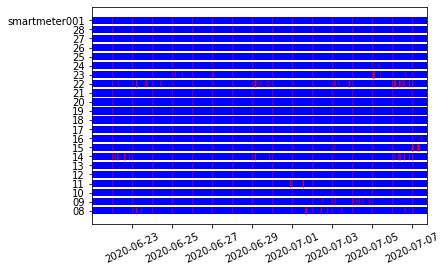

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ticks = []
indices = []
for index, dev in enumerate(list(devInfo.keys())):
    if "smartmeter" in dev: ticks.append(dev)
    else: ticks.append(dev.split("powermeter")[1])
    indices.append(index)
    start = mdates.date2num(datetime.fromtimestamp(devInfo[dev]["start"]))
    end = mdates.date2num(datetime.fromtimestamp(devInfo[dev]["end"]))
    ax.barh(index, end-start, align='center', left=start, color='b')
    for entry in devInfo[dev]["na"]:
        start = mdates.date2num(datetime.fromtimestamp(entry[0]))
        end = mdates.date2num(datetime.fromtimestamp(entry[1]))
        ax.barh(index, end-start, align='center', left=start, color='r', edgecolor='r', linewidth=0.5)

plt.yticks(indices, ticks)
plt.xticks(rotation=25)
ax.xaxis_date()
plt.show()

Plot top *numTopMostConsumers* consumers in accumulated bar plot, showing the contribution of the top most consumers to the avg total power consumption. Remaining consumers are accumulated as *rest*.
If smartmeter data is available, a black box will be shown representing, the total power consumption measured by the smartmeter. The missing portion of energy is the amount of power not metered.
If you specified all submeters, this represents the portion of electricty not metered separately

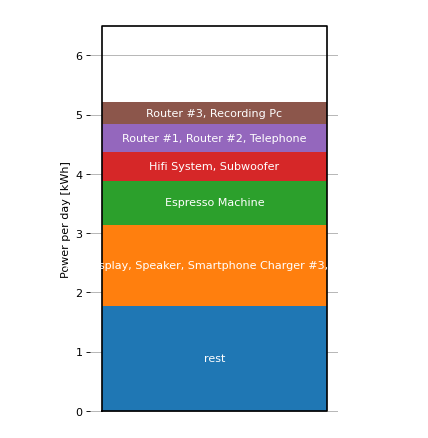

In [13]:
numTopMostConsumers = 5

submeterPows = [{"meter":dev, "avgPower":devInfo[dev]["avgPower"]} for dev in devInfo if dev != smartMeterName]
# sort for reversed avg power Large -> small
submeterPows = sorted(submeterPows, key=lambda x: x["avgPower"], reverse=True)
topMostMeters = submeterPows[:numTopMostConsumers]
if len(submeterPows) > numTopMostConsumers: metersRest = submeterPows[numTopMostConsumers:]
else: metersRest = []

# new figure with accumulated avg power
fig = plt.figure(figsize=(4, 7), dpi=80)
ax = fig.add_subplot(111)

accumulatedPower = sum([meter["avgPower"] for meter in metersRest])*24/1000.0
lastPower = 0
ax.fill_between([0,1], [accumulatedPower, accumulatedPower], [lastPower,lastPower])
ax.text(0.5, accumulatedPower/2.0, "rest", horizontalalignment='center', verticalalignment='center', color='w')
lastPower = accumulatedPower
for meter in topMostMeters:
    accumulatedPower += meter["avgPower"]*24/1000.0
    ax.fill_between([0,1], [accumulatedPower, accumulatedPower], [lastPower,lastPower])
    y_pos = (accumulatedPower-lastPower)/2.0 + lastPower
    if meter["meter"] in deviceMapping:
        label = hp.prettyfyApplianceName(str(", ".join(deviceMapping[meter["meter"]]["appliances"])))
    else:
        label = hp.prettyfyApplianceName(str(", ".join(meter["meter"])))
    ax.text(0.5, y_pos, label, horizontalalignment='center', verticalalignment='center', color='w')
    lastPower = accumulatedPower
if avgDaily is not None:
    ax.plot([0,1,1,0,0], [0,0,avgDaily,avgDaily,0], c='k')
ax.set_frame_on(False)
ax.set_axisbelow(True)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.yaxis.grid(True)
ax.set_ylabel("Power per day [kWh]")

# Show all plots
plt.show()